# heat loss labs

combined notebook for intro, scenario comparisons, and design tradeoffs.

assumes this notebook lives in the `notebooks/` folder of the repo.

In [5]:
import sys
import pathlib

repo_root = pathlib.Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import pandas as pd
from heat_loss_simulation import compute_specific_heat_loss, heat_loss_scenarios
from visualizations import (
    plot_house_thermal_map,
    plot_heat_loss_by_insulation,
    plot_cost_by_window_type,
    plot_component_breakdown,
)

In [6]:
def sweep_param(param_name, values, base):
    rows = []
    for v in values:
        params = dict(base)
        params[param_name] = v
        out = compute_specific_heat_loss(**params).copy()
        out[param_name] = v
        rows.append(out)
    return pd.concat(rows, ignore_index=True)

## 1. intro heat loss

In [7]:
base_params_intro = {
    'sqft_roof': 1800,
    'sqft_walls': 1500,
    'roof_material_type': 'wood',
    'wall_material_type': 'wood',
    'ambient_temp_F': 30,
    'T_inside_F': 70,
    'duration_hours': 24,
    'insulation_r_value': 'R13-R15',
    'air_changes_per_hour': 0.5,
    'window_area_sqft': 400,
    'window_type': 'double',
    'electricity_cost_per_kWh': 0.12,
}
base_params_intro

{'sqft_roof': 1800,
 'sqft_walls': 1500,
 'roof_material_type': 'wood',
 'wall_material_type': 'wood',
 'ambient_temp_F': 30,
 'T_inside_F': 70,
 'duration_hours': 24,
 'insulation_r_value': 'R13-R15',
 'air_changes_per_hour': 0.5,
 'window_area_sqft': 400,
 'window_type': 'double',
 'electricity_cost_per_kWh': 0.12}

In [8]:
df_intro = compute_specific_heat_loss(**base_params_intro)
df_intro

,sqft_roof,sqft_walls,roof_material_type,wall_material_type,ambient_temp_F,T_inside_F,duration_hours,insulation_r_value,air_changes_per_hour,window_area_sqft,...,Q_roof_kWh,Q_walls_kWh,Q_windows_kWh,Q_infiltration_kWh,Q_roof_pct,Q_walls_pct,Q_windows_pct,Q_infiltration_pct,total_cost,Q_total_kWh
0,1800,1500,wood,wood,30,70,24,R13-R15,0.5,400,...,34.427911,22.529631,55.494059,67.447578,19.137336,12.523476,30.847311,37.491877,21.587901,179.899179


In [9]:
ambient_range = [20, 30, 40, 50]
df_ambient = sweep_param('ambient_temp_F', ambient_range, base_params_intro)
df_ambient[['ambient_temp_F', 'Q_total_kWh', 'total_cost']].round(2)

,ambient_temp_F,Q_total_kWh,total_cost
0,20,224.87,26.98
1,30,179.90,21.59
2,40,134.92,16.19
3,50,89.95,10.79


<Axes: >

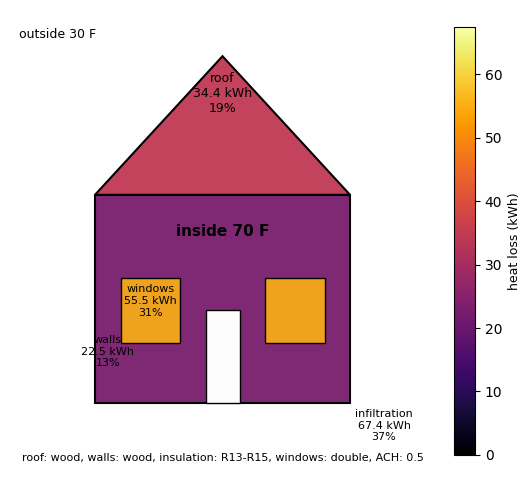

In [10]:
df_case_intro = compute_specific_heat_loss(**base_params_intro)
plot_house_thermal_map(df_case_intro)

## 2. scenario comparisons

In [11]:
scenarios = heat_loss_scenarios(
    sqft_roof=1800,
    sqft_walls=1500,
    ambient_temp_F=30,
    T_inside_F=70,
    duration_hours=24,
    air_changes_per_hour=0.5,
    window_area_sqft=400,
    electricity_cost_per_kWh=0.12,
)
scenarios.head()

,sqft_roof,sqft_walls,roof_material_type,wall_material_type,ambient_temp_F,T_inside_F,duration_hours,insulation_r_value,air_changes_per_hour,window_area_sqft,...,Q_roof_kWh,Q_walls_kWh,Q_windows_kWh,Q_infiltration_kWh,Q_roof_pct,Q_walls_pct,Q_windows_pct,Q_infiltration_pct,total_cost,Q_total_kWh
23,1800,1500,wood,wood,30,70,24,R34-R60,0.5,400,...,10.614744,8.157881,31.710891,67.447578,9.000801,6.917498,26.889338,57.192362,14.151731,117.931093
11,1800,1500,asphalt,wood,30,70,24,R34-R60,0.5,400,...,10.742599,8.157881,31.710891,67.447578,9.099351,6.910006,26.860218,57.130424,14.167074,118.058948
47,1800,1500,tile,wood,30,70,24,R34-R60,0.5,400,...,10.757323,8.157881,31.710891,67.447578,9.110687,6.909145,26.856868,57.123300,14.168841,118.073672
35,1800,1500,metal,wood,30,70,24,R34-R60,0.5,400,...,10.775027,8.157881,31.710891,67.447578,9.124313,6.908109,26.852842,57.114736,14.170965,118.091376
22,1800,1500,wood,wood,30,70,24,R22-R33,0.5,400,...,17.639531,12.893316,31.710891,67.447578,13.601166,9.941541,24.451052,52.006241,15.562958,129.691315


In [12]:
cols = [
    'roof_material_type',
    'insulation_r_value',
    'window_type',
    'Q_total_kWh',
    'total_cost',
]
scenarios[cols].sort_values('Q_total_kWh').head(10).round(2)

,roof_material_type,insulation_r_value,window_type,Q_total_kWh,total_cost
23,wood,R34-R60,triple,117.93,14.15
11,asphalt,R34-R60,triple,118.06,14.17
47,tile,R34-R60,triple,118.07,14.17
35,metal,R34-R60,triple,118.09,14.17
22,wood,R22-R33,triple,129.69,15.56
10,asphalt,R22-R33,triple,130.05,15.61
46,tile,R22-R33,triple,130.09,15.61
34,metal,R22-R33,triple,130.14,15.62
19,wood,R34-R60,double,141.71,17.01
7,asphalt,R34-R60,double,141.84,17.02


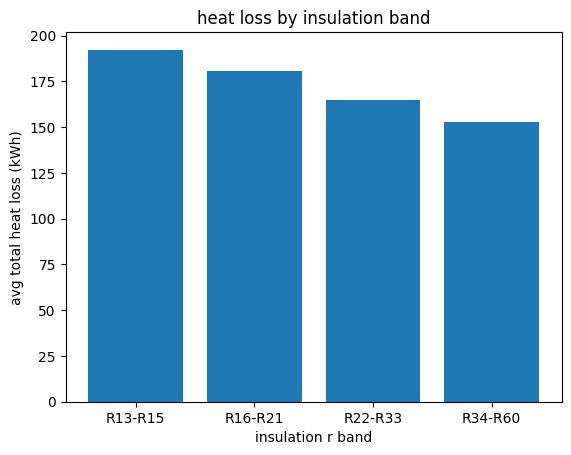

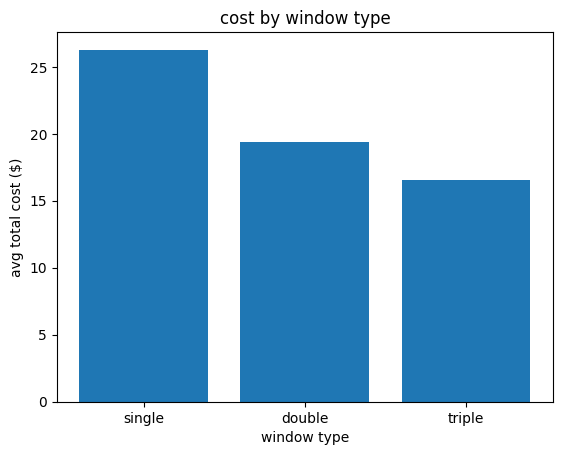

In [13]:
_ = plot_heat_loss_by_insulation(scenarios)
_ = plot_cost_by_window_type(scenarios)

In [14]:
subset = scenarios.query(
    "roof_material_type == 'wood' and insulation_r_value == 'R22-R33'"
)
subset[['window_type', 'Q_total_kWh', 'total_cost']].sort_values('Q_total_kWh')

,window_type,Q_total_kWh,total_cost
22,triple,129.691315,15.562958
18,double,153.474483,18.416938
14,single,210.950473,25.314057


## 3. design tradeoffs

In [15]:
base_tradeoffs = {
    'sqft_roof': 1800,
    'sqft_walls': 1500,
    'roof_material_type': 'wood',
    'wall_material_type': 'wood',
    'ambient_temp_F': 30,
    'T_inside_F': 70,
    'duration_hours': 24,
    'insulation_r_value': 'R22-R33',
    'air_changes_per_hour': 0.5,
    'window_area_sqft': 400,
    'window_type': 'double',
    'electricity_cost_per_kWh': 0.12,
}
df_base_tradeoffs = compute_specific_heat_loss(**base_tradeoffs)
df_base_tradeoffs

,sqft_roof,sqft_walls,roof_material_type,wall_material_type,ambient_temp_F,T_inside_F,duration_hours,insulation_r_value,air_changes_per_hour,window_area_sqft,...,Q_roof_kWh,Q_walls_kWh,Q_windows_kWh,Q_infiltration_kWh,Q_roof_pct,Q_walls_pct,Q_windows_pct,Q_infiltration_pct,total_cost,Q_total_kWh
0,1800,1500,wood,wood,30,70,24,R22-R33,0.5,400,...,17.639531,12.893316,55.494059,67.447578,11.493462,8.400951,36.158492,43.947096,18.416938,153.474483


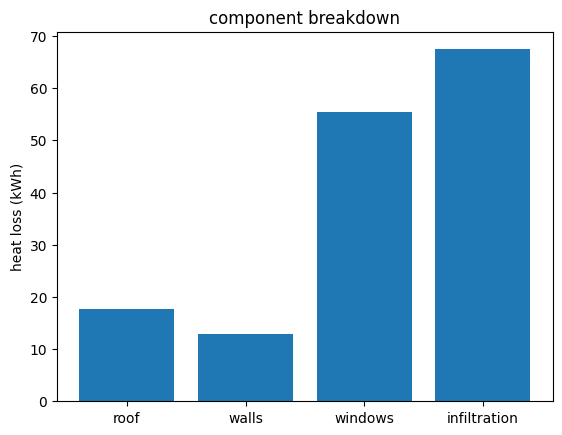

In [16]:
_ = plot_component_breakdown(df_base_tradeoffs)

In [17]:
insulation_values = ['R13-R15', 'R16-R21', 'R22-R33', 'R34-R60']
df_insulation = sweep_param('insulation_r_value', insulation_values, base_tradeoffs)
df_insulation[['insulation_r_value', 'Q_total_kWh', 'total_cost']].round(2)

,insulation_r_value,Q_total_kWh,total_cost
0,R13-R15,179.90,21.59
1,R16-R21,168.57,20.23
2,R22-R33,153.47,18.42
3,R34-R60,141.71,17.01


In [18]:
window_values = ['single', 'double', 'triple']
df_windows = sweep_param('window_type', window_values, base_tradeoffs)
df_windows[['window_type', 'Q_total_kWh', 'total_cost']].round(2)

,window_type,Q_total_kWh,total_cost
0,single,210.95,25.31
1,double,153.47,18.42
2,triple,129.69,15.56


In [19]:
ach_values = [0.3, 0.5, 0.7, 1.0]
df_ach = sweep_param('air_changes_per_hour', ach_values, base_tradeoffs)
df_ach[['air_changes_per_hour', 'Q_total_kWh', 'total_cost']].round(2)

,air_changes_per_hour,Q_total_kWh,total_cost
0,0.3,126.50,15.18
1,0.5,153.47,18.42
2,0.7,180.45,21.65
3,1.0,220.92,26.51
